In [225]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import itertools
import sys

sys.path.append("..")

from utility_functions import (calculate_model_performance,
                               plot_ROC,
                               one_hot_encode,
                               split_data_as,
                               grid_search,
                               shuffled,
                               timeit)

EPSILON = 10e-08


def get_shapes(any_):
    for array in any_:
        try:
            print(array.shape)
        except:
            print("NONE")
    print("\n")


# ============= ACTIVATION FUNCTIONS ===============#

def sigmoid(Z, prime=False):
    # np.
    if prime:
        return sigmoid(Z) * (1 - sigmoid(Z))
    return 1 / (1 + np.exp(-Z))


def linear(Z, prime=False):
    if prime:
        return np.ones_like(Z)
    return Z


def relu(Z, alpha=0.01, prime=False):
    if prime:
        Z_relu = np.ones_like(Z, dtype=np.float64)
        Z_relu[Z < 0] = alpha
        return Z_relu
    return np.where(Z < 0, alpha * Z, Z)


def tanh(Z, prime=False):
    # np.tanh() could be used directly to speed this up
    if prime:
        return 1 - np.power(tanh(Z), 2)
    return (2 / (1 + np.exp(-2 * Z))) - 1


def elu(Z, prime=False):
    # https://mlfromscratch.com/activation-functions-explained/#/
    alpha = 0.2
    if prime:
        return np.where(Z < 0, alpha * (np.exp(Z)), 1)
    return np.where(Z < 0, alpha * (np.exp(Z) - 1), Z)


def softmax(Z, prime=False):
    # https://deepnotes.io/softmax-crossentropy
    # max(Z) term is added to stabilise the function.
    exps = np.exp(Z - np.max(Z))
    return exps / np.sum(exps, axis=0)


# References
# https://mc.ai/multilayered-neural-network-from-scratch-using-python/
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
# https://www.coursera.org/learn/machine-learning/home/week/5
# https://www.coursera.org/specializations/deep-learning
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network.py
# https://github.com/JWarmenhoven/Coursera-Machine-Learning

class NeuralNetwork:

    def __init__(
            self,
            input_layer: tuple,
            hidden_layer: list,  # list of tuples
            output_layer: int,
            batch_size=16,
            alpha=1,
            optimizer="SGD",
            penalty="l2",
            lambd="0.1",
            epoch=500,
            random_state=42,
            verbose=True,
            metrics="accuracy"
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.mini_batch_size = batch_size
        self.alpha = alpha
        self.optimizer = optimizer
        self.penalty = penalty
        self.lambd = lambd
        self.epoch = epoch
        self.seed = random_state
        self.verbose = verbose
        self.metrics = metrics

        self.layers = len(self.weight_set_dimensions) + 1
        self.EPSILON = 10e-10


    def __str__(self):
        parameters = (
            "Input layer: {0}\n"
            "Hidden layer: {1}\n"
            "Output layer: {2}\n"
            "Batch size: {3}\n"
            "Learning rate: {4}\n"
            "Epoch: {5}\n"
            "Seed: {6}\n"
            "Verbose: {7}\n"
            "Metric: {8}"
        ).format(
            self.input_layer,
            " - ".join(map(str, self.hidden_layer)),
            self.output_layer,
            self.mini_batch_size,
            self.alpha,
            self.epoch,
            self.seed,
            self.verbose,
            self.metrics
        )
        return parameters

    def get_A(self, X):
        A, _ = self.forwardpass(X)
        return A

    def get_Z(self, X):
        _, Z = self.forwardpass(X)
        return Z
    
    # ============== LOSS FUNCTIONS ===============#

    # https://deepnotes.io/softmax-crossentropy

    def calculate_error(self, Y, Y_hat):
        # Y and Y_hat should be in the form of (no_of_classes, no_of_training_examples)
        cost = -np.sum(Y * np.log(Y_hat + EPSILON)) / self.m
        if self.penalty == "l1":
            penalise_by = np.sum(np.abs(self.W)) * (self.lambd / (2 * self.m))
            return cost + penalise_by
        elif self.penalty == "l2":
            penalise_by = np.sum(np.square(self.W)) * (self.lambd / (2 * self.m))
            return cost + penalise_by
        else:
            return cost


    def display_information(self, X, Y, epoch_no):
        model_performance_metrics = calculate_model_performance(
            np.argmax(Y, axis=0),
            self.predict(X)
        )
        print("%s: %.10f - epoch %s    iteration %s - loss %.20f" % (
            self.metrics,
            model_performance_metrics[self.metrics],
            epoch_no,
            self.no_of_iterations,
            calculate_error(Y,
                            self.get_A(X)[-1])
        )
              )

    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []

        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions

    def initialise_weights(self, layer=None):
        self.W = np.empty_like(range(self.layers), dtype=object)
        self.B = np.empty_like(range(self.layers), dtype=object)
        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            np.random.seed(self.seed)
            self.W[layer] = np.random.rand(y, x) / np.sqrt(self.dimensions[layer - 1])
            self.B[layer] = np.random.rand(y, 1)

    def forwardpass(self, X):
        Z = np.empty_like(range(self.layers), dtype=object)
        A = np.empty_like(range(self.layers), dtype=object)
        A[0] = X
        for layer in range(1, self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer])"

            Z[layer] = self.W[layer] @ A[layer - 1] + self.B[layer]
            A[layer] = eval(active_function + arg_to_pass_to_eval)
        return A, Z

    def backpropagation(self, Y, A, Z):
        self.delta = np.empty_like(range(self.layers), dtype=object)

        self.gradient_W = np.empty_like(range(self.layers), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers), dtype=object)

        self.delta[-1] = A[-1] - Y

        # We substract 1 here as delta_final is calculated seperately above
        for layer in reversed(range(1, self.layers - 1)):
            # 1 is substracted from layer as activation_functions start indexing from 0
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer], prime=True)"

            self.delta[layer] = (
                    self.W[layer + 1].T @ self.delta[layer + 1] *
                    eval(active_function + arg_to_pass_to_eval)
            )

        for layer in range(1, self.layers):
            self.gradient_W[layer] = (self.delta[layer] @ A[layer - 1].T) / self.m
            self.gradient_B[layer] = np.sum(self.delta[layer], axis=1, keepdims=True) / self.m
            
            if self.penalty == "l1":
                self.gradient_W[layer] += np.where(self.W[layer] < 0, -1, 1) * self.lambd / self.m
            # https://towardsdatascience.com/only-numpy-implementing-different-combination-of-l1-norm-l2-norm-l1-regularization-and-14b01a9773b
            elif self.penalty == "l2":
                self.gradient_W[layer] += self.W[layer] * self.lambd / self.m
            
        self.update_weights()


    def update_weights(self):
        if self.optimizer == "SGD":
            for layer in range(1, self.layers):
                self.W[layer] -= self.alpha * self.gradient_W[layer]
                self.B[layer] -= self.alpha * self.gradient_B[layer]

        elif self.optimizer["method"] == "SGDM":
            for layer in range(1, self.layers):
                beta = self.optimizer["beta"]
                self.v_dw[layer] = beta * self.v_dw[layer] + (1 - beta) * self.gradient_W[layer]
                self.v_db[layer] = beta * self.v_db[layer] + (1 - beta) * self.gradient_B[layer]

                self.W[layer] -= self.alpha * self.v_dw[layer]
                self.B[layer] -= self.alpha * self.v_db[layer]

        elif self.optimizer["method"] == "RMSP":
            for layer in range(1, self.layers):
                beta = self.optimizer["beta"]
                self.s_dw[layer] = beta * self.s_dw[layer] + (1 - beta) * np.square(self.gradient_W[layer])
                self.s_db[layer] = beta * self.s_db[layer] + (1 - beta) * np.square(self.gradient_B[layer])

                w_rms_grad = self.gradient_W[layer] / (np.sqrt(self.s_dw[layer]) + self.EPSILON)
                b_rms_grad = self.gradient_B[layer] / (np.sqrt(self.s_db[layer]) + self.EPSILON)

                self.W[layer] -= self.alpha * w_rms_grad
                self.B[layer] -= self.alpha * b_rms_grad

        elif self.optimizer["method"] == "ADAM":
            # EWA: Exponential weighted average
            # ToDo: Check if bias correction is necessary. The EWA will be inaccurate initially,
            # but it shouldn't take many iterations to compute correct EWA.
            for layer in range(1, self.layers):
                beta1 = self.optimizer["beta1"]
                beta2 = self.optimizer["beta2"]
                self.v_dw[layer] = beta1 * self.v_dw[layer] + (1 - beta1) * self.gradient_W[layer]
                self.v_db[layer] = beta1 * self.v_db[layer] + (1 - beta1) * self.gradient_B[layer]

                self.s_dw[layer] = beta2 * self.s_dw[layer] + (1 - beta2) * np.square(self.gradient_W[layer])
                self.s_db[layer] = beta2 * self.s_db[layer] + (1 - beta2) * np.square(self.gradient_B[layer])

                v_dw_corrected = self.v_dw[layer] / (1 - beta1 ** self.no_of_iterations)
                s_dw_corrected = self.s_dw[layer] / (1 - beta2 ** self.no_of_iterations)

                v_db_corrected = self.v_db[layer] / (1 - beta1 ** self.no_of_iterations)
                s_db_corrected = self.s_db[layer] / (1 - beta2 ** self.no_of_iterations)

                self.W[layer] -= self.alpha * (v_dw_corrected / (np.sqrt(s_dw_corrected) + self.EPSILON))
                self.B[layer] -= self.alpha * (v_db_corrected / (np.sqrt(s_db_corrected) + self.EPSILON))


    def initialise_cache(self):
        self.v_dw = np.empty_like(range(self.layers), dtype=object)
        self.v_db = np.empty_like(range(self.layers), dtype=object)
    
        self.s_dw = np.empty_like(range(self.layers), dtype=object)
        self.s_db = np.empty_like(range(self.layers), dtype=object)

        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            self.v_dw[layer] = np.zeros((y, x))
            self.v_db[layer] = np.zeros((y, 1))
            
            self.s_dw[layer] = np.zeros((y, x))
            self.s_db[layer] = np.zeros((y, 1))


    @timeit
    def fit(self, X, Y):
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.initialise_weights()
        self.initialise_cache()

        # By default the method is SGD(Stochastic Gradient Descent) if one wishes to use
        # the whole batch, simply pass the number of traning examples available as the
        # batch size when instantiating the class
        self.no_of_iterations = 0
        shuffled = np.arange(self.m)
        if self.verbose:
            print("Initialising weights...")
            print("Starting the training...")
            print("Initial cost: %.10f\n" % calculate_error(Y, self.get_A(X)[-1]))
        for epoch_no in range(1, self.epoch + 1):
            np.random.shuffle(shuffled)
            X_shuffled = X[:, shuffled]
            Y_shuffled = Y[:, shuffled]
            for i in range(0, self.m, self.mini_batch_size):
                self.no_of_iterations += 1
                X_mini_batch = X_shuffled[:, i: i + self.mini_batch_size]
                Y_mini_batch = Y_shuffled[:, i: i + self.mini_batch_size]

                A, Z = self.forwardpass(X_mini_batch)
                self.backpropagation(Y_mini_batch, A, Z)
                if self.no_of_iterations % 100 == 0 and self.verbose:
                    self.display_information(X, Y, epoch_no)

    def predict(
            self,
            X: np.ndarray,
            return_prob_matrix=False
    ):
        """Predict the output given the training data.

            Returns the predicted values in two forms:

            1.either by picking up the highest value along the columns for every row,
                i.e. "np.argmax(self.A[-1].T, axis=1)"
            2.or by returning a matrix that is in the shape of Y.T where each column
                represents the probability of the instance belonging to that class.
                Please note that every column in Y.T represents a class. To be able to
                return the probability matrix, the final activation function must be
                softmax!
                i.e. "array([0.9650488423, 0.0354737543, 0.0005225966])"

        Args:
            X (numpy.ndarray): Training set in the shape of
                (no_of_features, no_of_training examples).
            return_prob_matrix (bool, optional): Returns the probability matrix if True.
                Defaults to False.

        Returns:
            numpy.ndarray:

            if return_prob_matrix is False, the output is in the shape of
                (no_of_training_examples, 1)
            if return_prob_matrix is True, the output is in the shape of
                (no_of_training_examples, no_of_features)
        """
        A, Z = self.forwardpass(X)
        if return_prob_matrix:
            np.set_printoptions(precision=10, suppress=True)
            return A[-1].T
        return np.argmax(A[-1].T, axis=1)

# Testing with benchmark datasets

## 1.Iris Dataset

In [226]:
from sklearn.datasets import load_iris
data = load_iris()

x = data.data[:,[0,2]]
y = data.target

X = x.T
Y = one_hot_encode(y).T

In [227]:
print(X.shape)
print(Y.shape)

(2, 150)
(3, 150)


In [240]:
model = NeuralNetwork(
    input_layer=(2, 'relu'),
    hidden_layer=[(50,'relu'), (25,'relu'), (4,'softmax')],
    output_layer=3,
    batch_size=8,
    optimizer={"method": "ADAM", "beta1": 0.9, "beta2": 0.999},
    penalty = "l2",
    lambd=0.01,
    epoch=1000,
    alpha=0.001
)

model.fit(X,Y)

Initialising weights...
Starting the training...
Initial cost: 8.3912085458

accuracy: 33.3333333331 - epoch 6    iteration 100 - loss 1.00968707669045243414
accuracy: 43.3333333330 - epoch 11    iteration 200 - loss 0.97572024984930749714
accuracy: 66.6666666662 - epoch 16    iteration 300 - loss 0.93131245325476152974
accuracy: 66.6666666662 - epoch 22    iteration 400 - loss 0.85891234586887377223
accuracy: 66.6666666662 - epoch 27    iteration 500 - loss 0.73979122561606369679
accuracy: 66.6666666662 - epoch 32    iteration 600 - loss 0.59087475720012594405
accuracy: 91.9999999994 - epoch 37    iteration 700 - loss 0.48731067833032654102
accuracy: 90.6666666661 - epoch 43    iteration 800 - loss 0.41763780152733581685
accuracy: 89.9999999994 - epoch 48    iteration 900 - loss 0.35424664859296473018
accuracy: 95.3333333327 - epoch 53    iteration 1000 - loss 0.29743824866187779099
accuracy: 93.3333333327 - epoch 58    iteration 1100 - loss 0.25769978956197819864
accuracy: 91.9999999

In [242]:
calculate_model_performance(np.argmax(Y, axis=0),
                           model.predict(X))

{'F1': 95.83333333083769,
 'accuracy': 97.33333333268445,
 'false_positive_rate': 0.0,
 'precision': 99.9999999978261,
 'prevalence': 33.33333333311111,
 'sensitivity/recall': 91.99999999816,
 'specificity': 99.999999999}

In [ ]:
results_dict_all_models, results_average_dict, models = grid_search(
    x,
    y,
    clf=NeuralNetwork,
    lst_metrics=["F1", "accuracy"],
    sort_by = "accuracy",
    n_folds=5,
    dict_param_grid={
        'batch_size': [8, 16, 32],
        'input_layer': [(2, 'relu')],
        'hidden_layer': [
            [(4,'relu'), (4,'softmax')],
            [(4,'sigmoid'),(4,'softmax')]
        ],
        'optimizer': [
            {
                "method": "RMSP",
                "beta": 0.9
            }
        ],
        'output_layer': [3],
        'alpha': [0.001],
        'verbose': [False],
        'epoch': [1000]
    }
)

C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


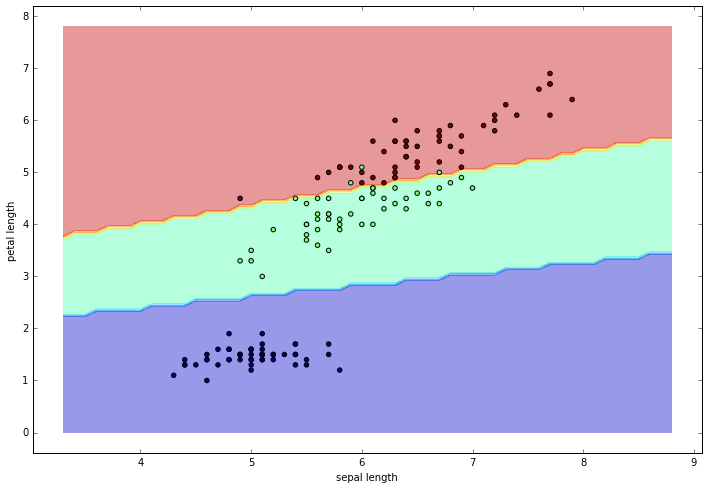

In [241]:
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')

plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

## 2.Make Moons dataset

In [243]:
from sklearn.datasets import make_moons

x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
Y = one_hot_encode(y).T

print(X.shape)
print(Y.shape)

(2, 1500)
(2, 1500)


In [254]:
model = NeuralNetwork(
    input_layer=(X.shape[0], 'relu'),
    hidden_layer=[(10,'relu'), (4,'softmax')],
    output_layer=Y.shape[0],
    batch_size=16,
    optimizer=
    {
        "method": "ADAM",
        "beta1": 0.9,
        "beta2": 0.999
    },
    penalty = "l2",
    lambd=0.001,
    epoch=100,
    alpha=0.1
)

model.fit(X,Y)

Initialising weights...
Starting the training...
Initial cost: 0.7257890008

accuracy: 89.9333333333 - epoch 2    iteration 100 - loss 0.20678830950132115474
accuracy: 90.6666666666 - epoch 3    iteration 200 - loss 0.18760975482321642915
accuracy: 90.3333333333 - epoch 4    iteration 300 - loss 0.20120697852448521381
accuracy: 89.8666666666 - epoch 5    iteration 400 - loss 0.19838528646852035542
accuracy: 90.8666666666 - epoch 6    iteration 500 - loss 0.18203501599547622369
accuracy: 91.3333333333 - epoch 7    iteration 600 - loss 0.18047008805975750523
accuracy: 89.6666666666 - epoch 8    iteration 700 - loss 0.21540359134801748131
accuracy: 90.5333333333 - epoch 9    iteration 800 - loss 0.18465880200409848233
accuracy: 90.8666666666 - epoch 10    iteration 900 - loss 0.18763499900852484426
accuracy: 90.9333333333 - epoch 11    iteration 1000 - loss 0.20425738210805358119
accuracy: 90.7333333333 - epoch 12    iteration 1100 - loss 0.18382022180199486527
accuracy: 88.3333333333 - e

C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


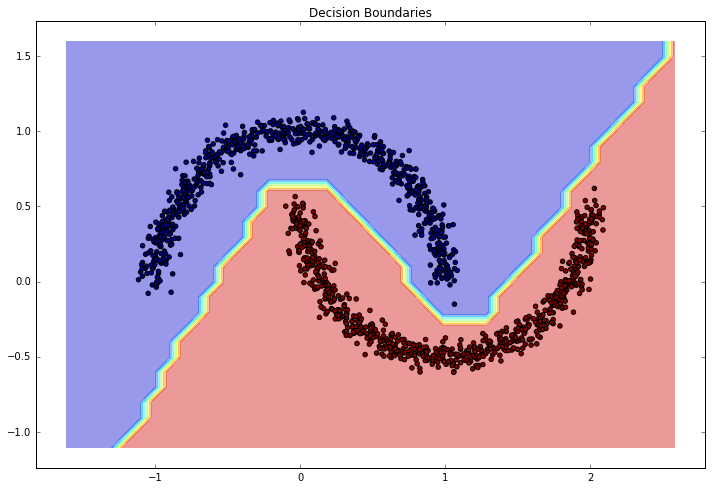

In [255]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 0.5, dt[:, 0].max() + 0.5
y_min, y_max = dt[:, 1].min() - 0.5, dt[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y, s=20, edgecolor='k')
plt.title('Decision Boundaries')

## 3.Andrew NG Assignment 2 Dataset

In [256]:
ex2data2 = np.loadtxt("../ex2/data/ex2data2.txt", delimiter=",")

x = ex2data2[:, :-1]
y = ex2data2[:, -1]

X = x.T
Y = one_hot_encode(y).T

In [257]:
print(X.shape)
print(Y.shape)

(2, 118)
(2, 118)


In [259]:
model = NeuralNetwork(
    input_layer=(X.shape[0], 'relu'),
    hidden_layer=[(10,'relu'), (4,'softmax')],
    output_layer=Y.shape[0],
    batch_size=8,
    optimizer={"method": "ADAM", "beta1": 0.9, "beta2": 0.999},
    penalty = "l2",
    lambd=0.05,
    epoch=1500,
    alpha=0.001
)

model.fit(X,Y)

Initialising weights...
Starting the training...
Initial cost: 0.7083513328

accuracy: 47.4576271182 - epoch 7    iteration 100 - loss 0.68941080950298072594
accuracy: 49.9999999996 - epoch 14    iteration 200 - loss 0.68837174895280084375
accuracy: 49.9999999996 - epoch 20    iteration 300 - loss 0.68741931203424777586
accuracy: 52.5423728809 - epoch 27    iteration 400 - loss 0.68617393863907094609
accuracy: 49.1525423725 - epoch 34    iteration 500 - loss 0.68474496577717580692
accuracy: 49.1525423725 - epoch 40    iteration 600 - loss 0.68328997950650616211
accuracy: 52.5423728809 - epoch 47    iteration 700 - loss 0.68161569314583747570
accuracy: 54.2372881351 - epoch 54    iteration 800 - loss 0.67987888169860499765
accuracy: 57.6271186436 - epoch 60    iteration 900 - loss 0.67783789563470753237
accuracy: 57.6271186436 - epoch 67    iteration 1000 - loss 0.67573735425408276711
accuracy: 57.6271186436 - epoch 74    iteration 1100 - loss 0.67332856174598221255
accuracy: 58.4745762

In [199]:
results_dict_all_models, results_average_dict, models = grid_search_stratified(
    x,
    y,
    clf=NeuralNetwork,
    metrics=["F1", "accuracy"],
    sort_by = "accuracy",
    n_fold=6,
    param_grid_dict={
        'batch_size': [16, 32],
        'input_layer': [(2, 'relu')],
        'hidden_layer': [
            [(4,'relu'), (4,'relu'), (4,'softmax')],
            [(4,'sigmoid'),(4,'softmax')]
        ],
        'output_layer': [2],
        'alpha': [2, 4],
        'verbose': [False],
        'epoch': [5000]
    }
)

NameError: name 'grid_search_stratified' is not defined

In [ ]:
results_average_dict

In [ ]:
print(models["model_5"])

C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


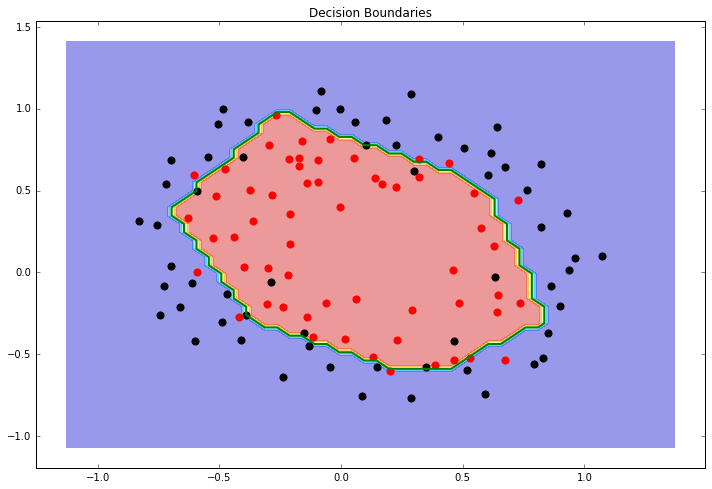

In [260]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
X = ex2data2

x1_min, x1_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3,
x2_min, x2_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3,
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()].T) 

negatives = ex2data2[ex2data2[:, -1] == 0]
positives = ex2data2[ex2data2[:, -1] == 1]

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(negatives[:, 0], negatives[:, 1],s=50, color='k')
plt.scatter(positives[:, 0], positives[:, 1],s=50, color='r')
plt.title('Decision Boundaries')

plt.contour(xx1, xx2, Z, [0.5], linewidths=2, colors="g")

# MNIST dataset

In [262]:
from scipy.io import loadmat
data = loadmat('../ex3/data/ex3data1.mat')
data.keys()

dict_keys(['y', '__header__', '__version__', '__globals__', 'X'])

In [263]:
x = data["X"]
y = data["y"]
y[y==10] = 0

In [264]:
X = x.T
Y = one_hot_encode(y).T

In [265]:
print(X.shape)
print(Y.shape)

(400, 5000)
(10, 5000)


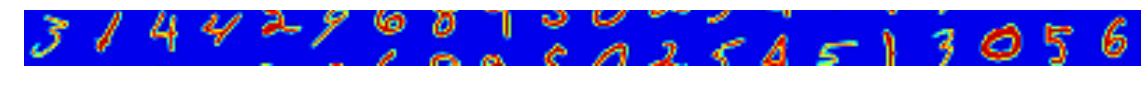

In [266]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

sample = np.random.choice(data["X"].shape[0], 20)
ax.imshow(data["X"][sample,1:].reshape(-1,20).T)
ax.axis('off');

In [ ]:
model = NeuralNetwork(
    input_layer=(X.shape[0], 'relu'),
    hidden_layer=[(200,'relu'),(100,'relu'),(4,'softmax')],
    output_layer=Y.shape[0],
    batch_size=64,
    optimizer={"method": "ADAM", "beta1": 0.9, "beta2": 0.999},
    penalty = "l2",
    lambd=0.05,
    epoch=1500,
    alpha=0.001
)

model.fit(X,Y)

Initialising weights...
Starting the training...
Initial cost: 13.5652997635

accuracy: 10.0000000000 - epoch 2    iteration 100 - loss 2.33404726205136192618
accuracy: 18.8000000000 - epoch 3    iteration 200 - loss 2.25133461278363533609
accuracy: 34.5400000000 - epoch 4    iteration 300 - loss 1.97625877374434311129
accuracy: 45.6200000000 - epoch 6    iteration 400 - loss 1.58009708797493542143
accuracy: 59.1000000000 - epoch 7    iteration 500 - loss 1.24611260520071565061
accuracy: 66.2800000000 - epoch 8    iteration 600 - loss 1.03339205988014537496
accuracy: 71.7800000000 - epoch 9    iteration 700 - loss 0.89240494401786529810
accuracy: 75.2200000000 - epoch 11    iteration 800 - loss 0.81578847808162857635
accuracy: 77.0000000000 - epoch 12    iteration 900 - loss 0.74483613057180431127
accuracy: 78.2400000000 - epoch 13    iteration 1000 - loss 0.71816840368050294252
accuracy: 81.8400000000 - epoch 14    iteration 1100 - loss 0.63260424353569255640
accuracy: 82.8800000000 -

In [ ]:
model = NeuralNetwork(
    (X.shape[0], 'relu'),
    [(200, 'relu'), (100, 'relu'), (50, 'relu'), (10,'softmax')],
    Y.shape[0],
    batch_size=50,
    optimizer={
        "method": "RMSP",
        "beta": 0.9
                },
    epoch=100,
    alpha=0.001
)

model.fit(X,Y)

In [ ]:
model = NeuralNetwork(
    (X.shape[0], 'relu'),
    [(25,'relu'), (4,'softmax')],
    Y.shape[0],
    batch_size=50,
    optimizer={
        "method": "SGDM",
        "beta": 0.9
                },
    epoch=1000,
    alpha=6)

model.fit(X,Y)

In [138]:
results_dict_all_models, results_average_dict, models = grid_search(
    x,
    y,
    clf=NeuralNetwork,
    lst_metrics=["F1", "accuracy"],
    sort_by = "F1",
    n_folds=10,
    dict_param_grid={
        'batch_size': [64, 128, 256],
        'input_layer': [(x.shape[1], 'relu')],
        'hidden_layer': [
            [(50, 'relu'), (25, 'relu'), (10,'softmax')],
            [(200, 'relu'), (100, 'relu'), (50, 'relu'), (10,'softmax')]
        ],
        'optimizer':[
            {
                "method": "ADAM",
                "beta1": 0.9,
                "beta2": 0.999
            }
        ],
        'output_layer': [10],
        'alpha': [0.0001, 0.001],
        'verbose': [False],
        'epoch': [250]
    }
)


*********1/120*********
Running model 1 fold 1
func:'fit' -- took: 27.7436 sec

*********2/120*********
Running model 1 fold 2
func:'fit' -- took: 27.3636 sec

*********3/120*********
Running model 1 fold 3
func:'fit' -- took: 27.1771 sec

*********4/120*********
Running model 1 fold 4
func:'fit' -- took: 27.0076 sec

*********5/120*********
Running model 1 fold 5
func:'fit' -- took: 27.5761 sec

*********6/120*********
Running model 1 fold 6
func:'fit' -- took: 29.0080 sec

*********7/120*********
Running model 1 fold 7
func:'fit' -- took: 28.0464 sec

*********8/120*********
Running model 1 fold 8
func:'fit' -- took: 27.0147 sec

*********9/120*********
Running model 1 fold 9
func:'fit' -- took: 27.5926 sec

*********10/120*********
Running model 1 fold 10
func:'fit' -- took: 27.1691 sec

*********11/120*********
Running model 2 fold 1
func:'fit' -- took: 27.9341 sec

*********12/120*********
Running model 2 fold 2
func:'fit' -- took: 27.6716 sec

*********13/120*********
Running mo

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:47: RuntimeWarning: invalid value encountered in less


func:'fit' -- took: 169.5607 sec

*********34/120*********
Running model 4 fold 4
func:'fit' -- took: 163.0635 sec

*********35/120*********
Running model 4 fold 5
func:'fit' -- took: 166.0595 sec

*********36/120*********
Running model 4 fold 6
func:'fit' -- took: 170.0473 sec

*********37/120*********
Running model 4 fold 7
func:'fit' -- took: 164.5768 sec

*********38/120*********
Running model 4 fold 8
func:'fit' -- took: 166.0224 sec

*********39/120*********
Running model 4 fold 9
func:'fit' -- took: 165.6858 sec

*********40/120*********
Running model 4 fold 10
func:'fit' -- took: 172.4002 sec

*********41/120*********
Running model 5 fold 1
func:'fit' -- took: 19.1474 sec

*********42/120*********
Running model 5 fold 2
func:'fit' -- took: 17.4733 sec

*********43/120*********
Running model 5 fold 3
func:'fit' -- took: 17.6518 sec

*********44/120*********
Running model 5 fold 4
func:'fit' -- took: 17.4739 sec

*********45/120*********
Running model 5 fold 5
func:'fit' -- took:

In [ ]:
results_average_dict

In [ ]:
print(models["model_1"])

In [ ]:
def display_miss_clasifications(model, digits_to_display):
    count = 0
    for index, (act, predicted) in enumerate(zip(np.argmax(Y,axis=0), model.predict(X))):
        if act != predicted:
            fig, ax = plt.subplots(figsize = (2,2))
            ax.set_title("%s: act %s --- predicted %s" %(index, act, predicted))
            ax.imshow(X[:, index].reshape(-1,20).T)
            ax.axis('off');
            count += 1
        if count == digits_to_display:
            break

In [ ]:
display_miss_clasifications(model, 50)